In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="4"

Wed Jan 17 23:21:16 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   36C    P0    64W / 300W |   9053MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [4]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.uniform_prior import Prior
from model.latent.bdmin_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [7]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 3
hp.out_dim = 3
hp.z_dim = 128
hp.h_dims = [32, 64, 128, 256, 512]
hp.M = 1024
hp.N = 256
hp.activation = F.sigmoid

In [8]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.99169921875
encoder.convs 5.9912109375
encoder.linear 1.00048828125
prior 0.0
latent 0.0
decoder 7.028697967529297
decoder.linear 1.0078125
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [9]:
save_dir = '/data/scpark/save/lse/train_celeba/train01.17-11/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 1505, model_list, optimizer_list)

total 0


### Dataset

In [10]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

test_transforms = transforms.Compose([transforms.CenterCrop(148),
                                      transforms.Resize(hp.size),
                                      transforms.ToTensor(),])
test_dataset = MyCelebA(root, split='test', transform=test_transforms, download=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)
print('done')

done


### Preprocess

In [11]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [12]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

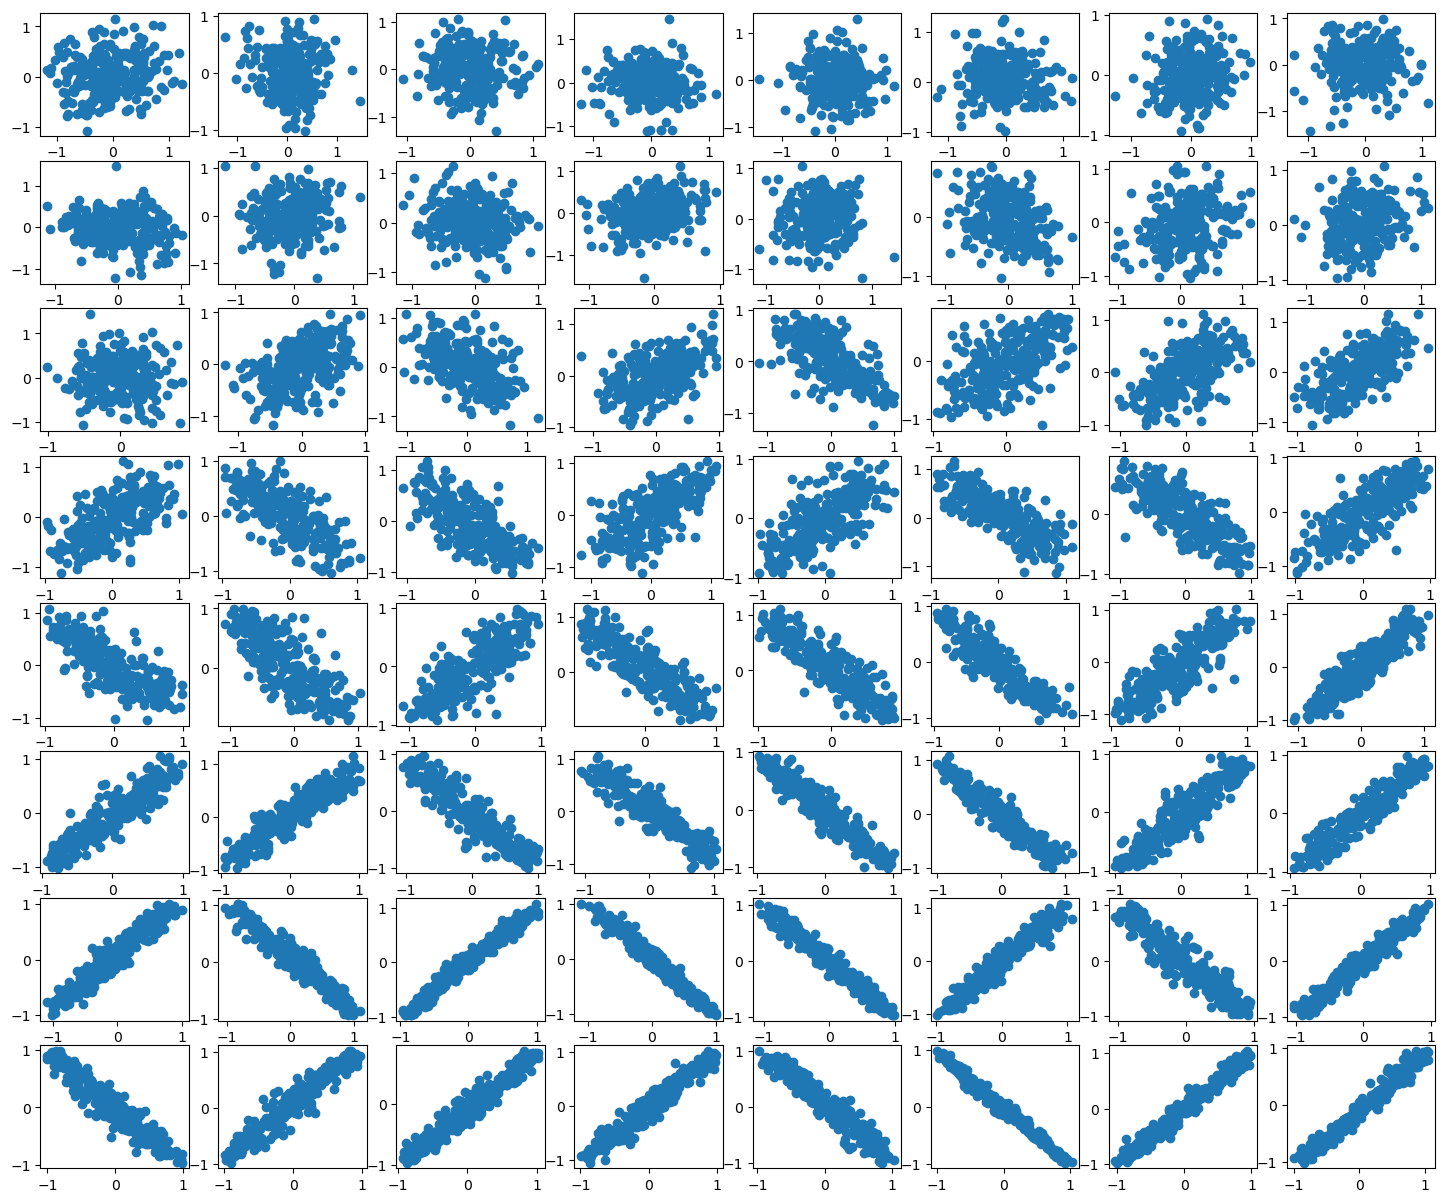

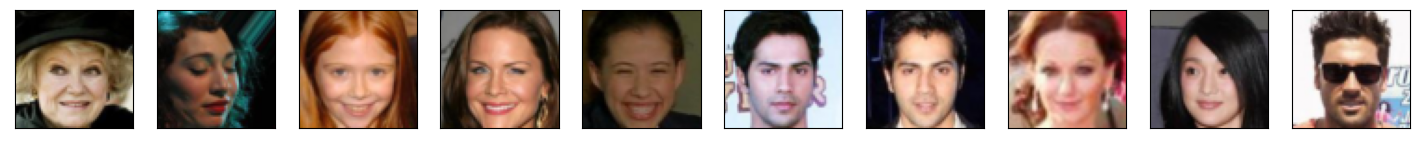

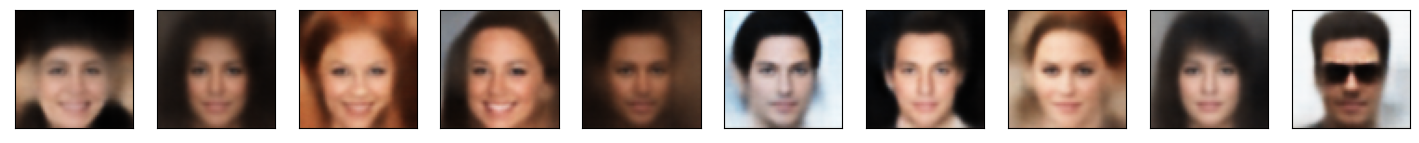

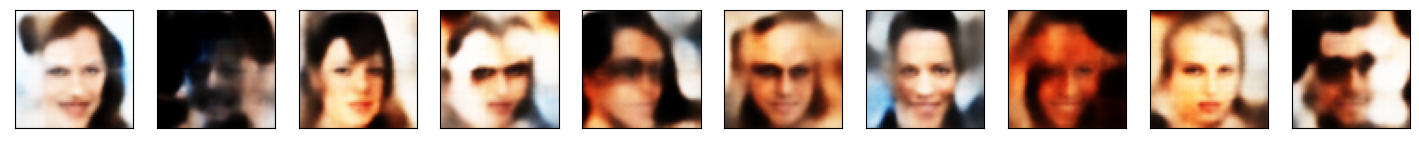

4001
lse_loss 0.00032697321148589253
recon_loss 0.009715434163808823
4002
lse_loss 0.00030608312226831913
recon_loss 0.010788857005536556
4003
lse_loss 0.00036339450161904097
recon_loss 0.01002182811498642
4004
lse_loss 0.00035009090788662434
recon_loss 0.010369827970862389
4005
lse_loss 0.00034261931432411075
recon_loss 0.009399554692208767
4006
lse_loss 0.0003952563856728375
recon_loss 0.009945977479219437
4007
lse_loss 0.0003590819542296231
recon_loss 0.010523594915866852
4008
lse_loss 0.0003132393176201731
recon_loss 0.010125535540282726
4009
lse_loss 0.00033787963911890984
recon_loss 0.010632408782839775
4010
lse_loss 0.0003290668537374586
recon_loss 0.010498670861124992
4011
lse_loss 0.00040665280539542437
recon_loss 0.010652193799614906
4012
lse_loss 0.0003206558176316321
recon_loss 0.010872956365346909
4013
lse_loss 0.0003392215585336089
recon_loss 0.011364459060132504
4014
lse_loss 0.0003151962300762534
recon_loss 0.010517923161387444
4015
lse_loss 0.0002730772248469293
recon_

4122
lse_loss 0.0003405257884878665
recon_loss 0.010680804960429668
4123
lse_loss 0.0003461814485490322
recon_loss 0.010106757283210754
4124
lse_loss 0.0002913613279815763
recon_loss 0.009579723700881004
4125
lse_loss 0.00036594108678400517
recon_loss 0.011751408688724041
4126
lse_loss 0.0002799066132865846
recon_loss 0.010465341620147228
4127
lse_loss 0.000317497382638976
recon_loss 0.009953673928976059
4128
lse_loss 0.0003568981774151325
recon_loss 0.009956113062798977
4129
lse_loss 0.00036365119740366936
recon_loss 0.010692751035094261
4130
lse_loss 0.00035764038329944015
recon_loss 0.0095880888402462
4131
lse_loss 0.00035493052564561367
recon_loss 0.010457850061357021
4132
lse_loss 0.0003618675982579589
recon_loss 0.01010473445057869
4133
lse_loss 0.0003567165113054216
recon_loss 0.010651259683072567
4134
lse_loss 0.00031419796869158745
recon_loss 0.0108575988560915
4135
lse_loss 0.00037663793773390353
recon_loss 0.01039634458720684
4136
lse_loss 0.00032824015943333507
recon_loss 0

4243
lse_loss 0.00035533629124984145
recon_loss 0.01103860791772604
4244
lse_loss 0.0003648520214483142
recon_loss 0.011043112725019455
4245
lse_loss 0.0002915702643804252
recon_loss 0.009694382548332214
4246
lse_loss 0.00030695111490786076
recon_loss 0.009554365649819374
4247
lse_loss 0.0003308765881229192
recon_loss 0.00965653546154499
4248
lse_loss 0.00034587804111652076
recon_loss 0.010004846379160881
4249
lse_loss 0.0003356949600856751
recon_loss 0.009904528968036175
4250
lse_loss 0.0003013477544300258
recon_loss 0.011323741637170315
4251
lse_loss 0.0003957257140427828
recon_loss 0.011218483559787273
4252
lse_loss 0.0002913353964686394
recon_loss 0.010001691989600658
4253
lse_loss 0.00032585684675723314
recon_loss 0.010002721101045609
4254
lse_loss 0.00032886635744944215
recon_loss 0.009895308874547482
4255
lse_loss 0.0002834591723512858
recon_loss 0.010998981073498726
4256
lse_loss 0.00037412968231365085
recon_loss 0.010194526053965092
4257
lse_loss 0.0003460292937234044
recon_lo

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=1024)

            # Backward
            loss = 0
            for key in data.keys():
                if 'kl_loss' in key:
                    loss = loss + data[key] * 0.00025
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            z = data['z_copy'].data.cpu().numpy()
            plt.figure(figsize=[18, 15])
            for i in range(64):
                plt.subplot(8, 8, i+1)
                plt.scatter(z[:, 2*i], z[:, 2*i+1])
            plt.show()
        
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=1024)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = model.prior.sample(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')